#**Proyecto 2**

En este proyecto profundizarás lo desarrollado en el proyecto 01 (“Primer modelo de Machine Learning”). El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
properati = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/DS_Proyecto_01_Datos_Properati.csv')

In [ ]:
prope = properati.copy()

In [ ]:
print(prope.shape)

(146660, 19)


El trabajo se organiza en tres partes:

##PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

1.   Detección y eliminación de Outliers
2.   Encoding
3.   Imputación de valores faltantes
4.   Escalado de datos
5.   Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).


Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

> #### **Visualización de valores faltantes**

In [ ]:
# Cantidad de valores faltantes por columna
print(prope.isna().sum())

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64


In [ ]:
prope = prope.drop_duplicates()
print(prope.shape)

(144302, 19)


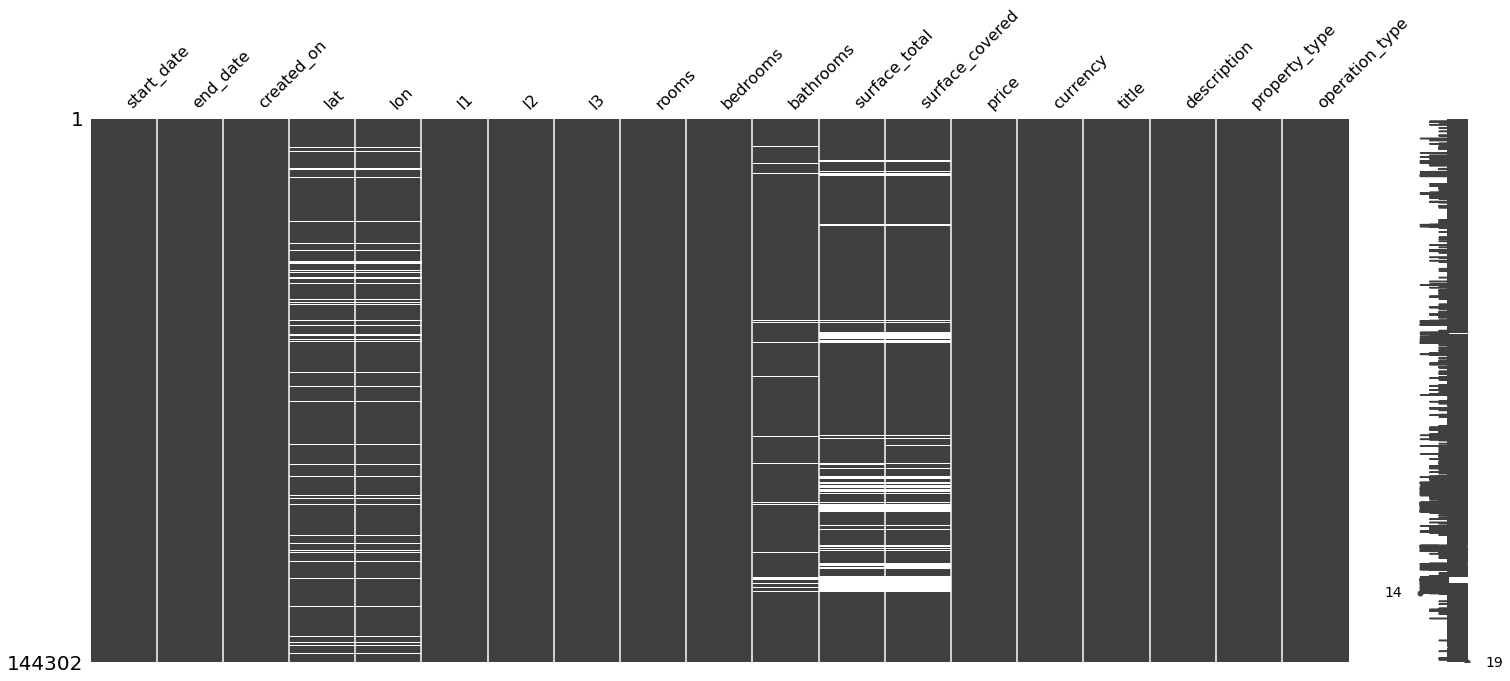

In [ ]:
import missingno as msno

# Visualize missing values as a matrix
msno.matrix(prope)

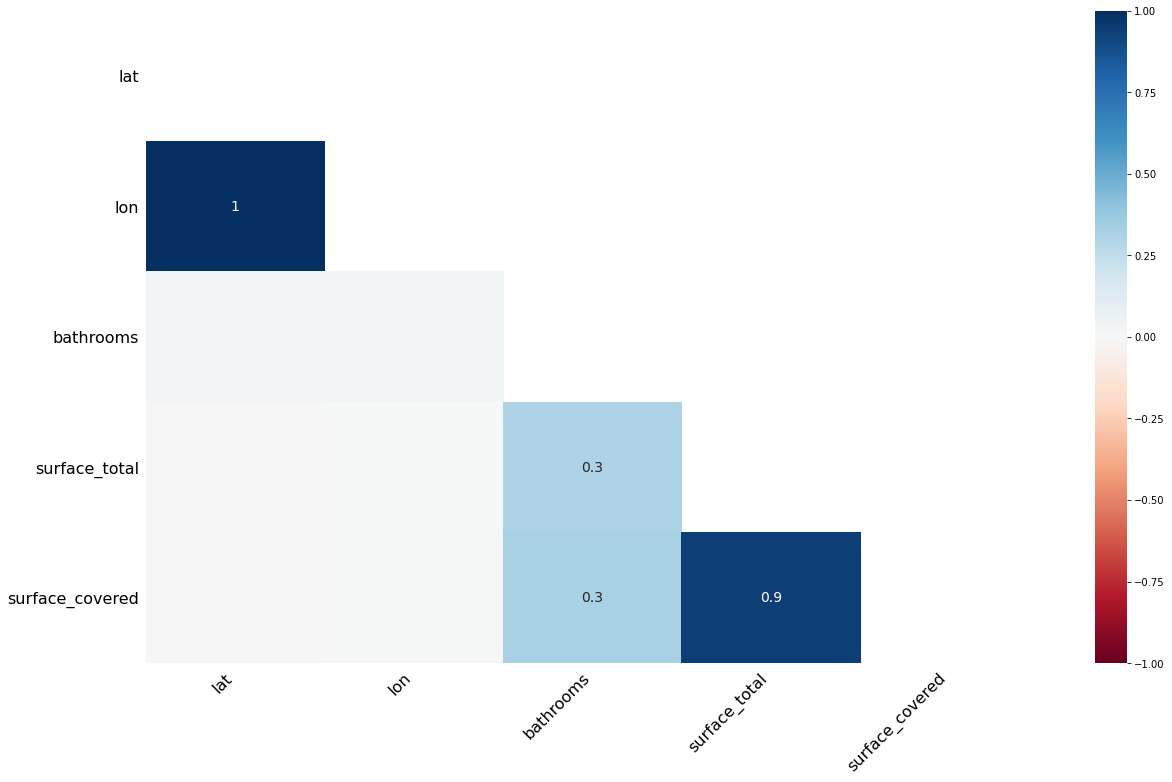

In [ ]:
import missingno as msno

# Visualize the correlation between the number of missing values in different columns as a heatmap
msno.heatmap(prope)

> #### **Valores atípicos (*outliers*)**

In [ ]:
#creo un dataframe con la media y la desviación estándar de los atributos que me interesan

estad = pd.DataFrame({
                      'media': prope[['rooms', 'surface_total', 'surface_covered', 'price']].mean(),
                      'desv_std': prope[['rooms', 'surface_total', 'surface_covered', 'price']].std()
                    })

estad.transpose()

,rooms,surface_total,surface_covered,price
media,3.083540,218.823413,113.379293,240694.635390
desv_std,1.420667,2054.620674,924.548575,317154.145007


In [ ]:
# asigno un umbral superior para poder detectar outliers
# adopto criterio de las 3 sigmas (concentra el 99.7% de los datos)

estad.loc[:,'umbral_sup'] = estad['media'] + 3 * estad['desv_std']   # agrego la fila

estad.transpose()

,rooms,surface_total,surface_covered,price
media,3.083540,218.823413,113.379293,2.406946e+05
desv_std,1.420667,2054.620674,924.548575,3.171541e+05
umbral_sup,7.345541,6382.685436,2887.025018,1.192157e+06


In [ ]:
# creación de un dataframe con los datos que quedan por encima del umbral superior

outliers = prope[(prope['rooms'] > estad['umbral_sup'].values[0]) |
                       (prope['surface_total'] > estad['umbral_sup'].values[1]) |
                       (prope['surface_covered'] > estad['umbral_sup'].values[2]) |
                       (prope['price'] > estad['umbral_sup'].values[3])
                       ]
outliers.shape

(3887, 19)

In [ ]:
# eliminación de las filas que contienen outliers en prope,
# indicando los índices de las instancias que presentan outliers

prope.drop(outliers.index, axis=0, inplace=True)

In [ ]:
print(prope.isna().sum())

start_date             0
end_date               0
created_on             0
lat                 9139
lon                 9173
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5674
surface_total      19893
surface_covered    20854
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64


> #### **Imputación de valores faltantes**

In [ ]:
# imputación de valores faltantes en latitud y longitud
# los completo con el promedio, teniendo en cuenta la ciudad/barrio (l3)

lon2 = prope[['lon', 'l3']].groupby('l3').agg(pd.Series.mean)
lat2 = prope[['lat', 'l3']].groupby('l3').agg(pd.Series.mean)
prope = prope.set_index('l3')   # porque el reemplazo es por ciudad
prope.lon.fillna(lon2.to_dict()['lon'], inplace=True)
prope.lat.fillna(lat2.to_dict()['lat'], inplace=True)
prope = prope.reset_index()

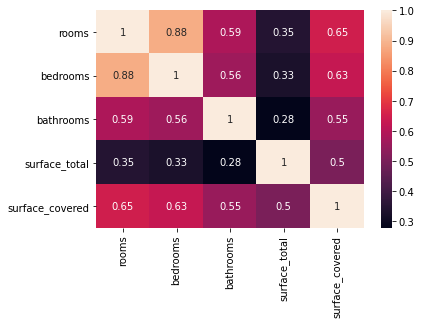

In [ ]:
# matriz de correlación para tener una idea sobre la correlación entre
# la cantidad de baños y los demás features

matriz_corr = prope[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].corr()
sns.heatmap(matriz_corr, annot=True)
plt.show()


Se observa que la cantidad de baños de una propiedad está correlacionada en un 59% con la cantidad de habitaciones que tiene la misma. Este dato será tenido en cuenta para imputar los datos faltantes en la cantidad de baños.

In [ ]:
# imputación de valores faltantes en bathrooms
# los completo con la mediana de la cantidad de baños, según el número de habitaciones de la propiedad

bathrooms2 = prope[['bathrooms', 'rooms']].groupby('rooms').agg(pd.Series.median)
prope = prope.set_index('rooms')
prope.bathrooms.fillna(bathrooms2.to_dict()['bathrooms'], inplace=True)
prope = prope.reset_index()

En la matriz de correlación también se observa que la superficie cubierta de una propiedad está correlacionada en un 65% con la cantidad de habitaciones. Este dato se considerará al momento de imputar las superficies cubiertas faltantes.
Una vez completados estos datos, se imputarán los datos faltantes en la columna de superficie total en base a la correlación que existe entre las superficies cubierta y total.



In [ ]:
pd.unique(prope['property_type'])

array(['Departamento', 'PH', 'Casa', 'Lote', 'Casa de campo', 'Oficina',
       'Otro', 'Local comercial', 'Cochera', 'Depósito'], dtype=object)

In [ ]:
# generación de dataframes para cada tipo de propiedad

prope_dpto = prope[prope['property_type']=='Departamento']
prope_ph = prope[prope['property_type']=='PH']
prope_casa = prope[prope['property_type']=='Casa']
prope_lote = prope[prope['property_type']=='Lote']
prope_ccampo = prope[prope['property_type']=='Casa de campo']
prope_oficina = prope[prope['property_type']=='Oficina']
prope_otro = prope[prope['property_type']=='Otro']
prope_local = prope[prope['property_type']=='Local comercial']
prope_cochera = prope[prope['property_type']=='Cochera']
prope_deposito = prope[prope['property_type']=='Depósito']

In [ ]:
# imputación de valores faltantes en superficie cubierta
# los completo con su promedio, teniendo en cuenta la cantidad de habitaciones

tipos = (prope_dpto, prope_ph, prope_casa, prope_lote, prope_ccampo, prope_oficina, prope_otro, prope_local, prope_cochera, prope_deposito)

for t in tipos:
  sc2 = t[['surface_covered', 'rooms']].groupby('rooms').agg(pd.Series.mean)
  prope = prope.set_index('rooms')
  prope.surface_covered.fillna(sc2.to_dict()['surface_covered'], inplace=True)
  prope = prope.reset_index()

In [ ]:
# imputación de valores faltantes en superficie total
# los completo con su promedio, teniendo en cuenta la superficie cubierta

st2 = prope[['surface_total', 'surface_covered']].groupby('surface_covered').agg(pd.Series.mean)
prope = prope.set_index('surface_covered')
prope.surface_total.fillna(st2.to_dict()['surface_total'], inplace=True)
prope = prope.reset_index()

In [ ]:
print(prope.isna().sum())

surface_covered    0
rooms              0
l3                 0
start_date         0
end_date           0
created_on         0
lat                0
lon                0
l1                 0
l2                 0
bedrooms           0
bathrooms          0
surface_total      1
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64


In [ ]:
# visualización del único valor faltante

unico_nan = prope[prope.isna().any(axis=1)]
unico_nan

,surface_covered,rooms,l3,start_date,end_date,created_on,lat,lon,l1,l2,bedrooms,bathrooms,surface_total,price,currency,title,description,property_type,operation_type
90329,683.0,6.0,Pilar,2020-01-17,9999-12-31,2020-01-17,-34.46886,-58.822307,Argentina,Bs.As. G.B.A. Zona Norte,5.0,6.0,NaN,760000.0,USD,Casa en Venta 6 ambientes La peregrina Pilar,Amplia casa de 680 mts cubiertos con parque so...,Casa,Venta


In [ ]:
print(prope.shape)

(140415, 19)


In [ ]:
# eliminación del único valor faltante
prope.dropna()

,surface_covered,rooms,l3,start_date,end_date,created_on,lat,lon,l1,l2,bedrooms,bathrooms,surface_total,price,currency,title,description,property_type,operation_type
0,140.0,7.0,San Cristobal,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,7.0,2.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,58.0,2.0,Boedo,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,1.0,2.0,70.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,45.0,2.0,Palermo,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,1.0,1.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,50.0,2.0,Palermo,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,1.0,1.0,85.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,35.0,2.0,La Plata,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,1.0,1.0,50.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140410,48.0,2.0,Berazategui,2019-07-31,2019-08-13,2019-07-31,-34.816348,-58.181963,Argentina,Bs.As. G.B.A. Zona Sur,1.0,1.0,54.0,165000.0,USD,Departamento en Venta en Barrio Privado Barran...,Departamento de 2 ambientesCocina con alacena ...,Departamento,Venta
140411,90.0,4.0,Pilar,2019-07-31,2019-08-14,2019-07-31,-34.446459,-58.937810,Argentina,Bs.As. G.B.A. Zona Norte,3.0,2.0,164.0,130000.0,USD,Venta departamentos tres dormitorios jardín co...,Muy buen duplex a estrenar en dos plantas más ...,Departamento,Venta
140412,35.0,1.0,Pilar,2019-07-31,2019-08-14,2019-07-31,-34.444633,-58.981606,Argentina,Bs.As. G.B.A. Zona Norte,1.0,1.0,50.0,73000.0,USD,Venta departamento de un ambiente Manzanares C...,"En los Condominios de Campo Manzanares Chico, ...",Departamento,Venta
140413,38.0,2.0,Pilar,2019-07-31,2019-08-14,2019-07-31,-34.444830,-58.981796,Argentina,Bs.As. G.B.A. Zona Norte,1.0,1.0,38.0,68000.0,USD,Departamento en Venta. Manzanares chico.,Broker: Maria 11Departamento de dos ambientes ...,Departamento,Venta


In [ ]:
# control de las columnas con valores imputados, que no tengan valores negativos
print(
    (prope['surface_total']<0).sum(),
    (prope['surface_covered']<0).sum(),
    (prope['bathrooms']<0).sum()
)

0 0 0


> #### **Filtrado de propiedades con superficie cubierta mayor a la total**

In [ ]:
# se descartan las propiedades que figuren con superficie cubierta mayor a la total
prope = prope.loc[(prope['surface_total'] >= prope['surface_covered']),:]

In [ ]:
print(prope.shape)

(138712, 19)


> #### ***Encoding* de barrios mediante precio por m$^2$**

In [ ]:
# se agrega una columna con el precio por m2

prope.loc[:,'price_m2'] = prope['price'] / prope['surface_total']



---



#### Comparación con el modelo elegido en el proyecto 1

In [ ]:
estad.transpose()

,rooms,surface_total,surface_covered,price
media,3.083540,218.823413,113.379293,2.406946e+05
desv_std,1.420667,2054.620674,924.548575,3.171541e+05
umbral_sup,7.345541,6382.685436,2887.025018,1.192157e+06


In [ ]:
propefil = prope.copy()

propefil = propefil[
                 (propefil['l2']=='Capital Federal') &
                ((propefil['property_type'] == 'Departamento') |
                 (propefil['property_type'] == 'Casa') |
                 (propefil['property_type'] == 'PH')) &
                 (15 < propefil['surface_total']) &
                 (1000 > propefil['surface_total']) &
                 (propefil['price'] < 4000000)                 
                ]

propefil = propefil.drop(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'], axis=1)


In [ ]:
propefil.shape

(86444, 8)

In [ ]:
# escalado de datos filtrados para comparar con el proyecto 1

scal = StandardScaler()
scal.fit(propefil[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']])
propefil[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']] = scal.transform(propefil[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']])
propefil.head()

,surface_covered,rooms,bedrooms,bathrooms,surface_total,price,property_type,price_m2
0,1.321547,3.518009,5.140273,0.651287,0.156364,153000.0,Departamento,-1.251406
1,-0.361643,-0.756632,-0.913236,0.651287,-0.384658,159000.0,PH,-0.199443
2,-0.628490,-0.756632,-0.913236,-0.648400,-0.577880,125000.0,PH,0.252512
3,-0.525856,-0.756632,-0.913236,-0.648400,-0.268725,295000.0,PH,0.870897
5,-0.402696,-0.756632,-0.913236,-0.648400,-0.492863,150000.0,PH,0.163963


In [ ]:
# el tipo de propiedad es una variable categórica en donde no existe relacion de orden
# por este motivo se aplica one-hot encoding a los datos filtrados

pd.get_dummies(propefil, columns = ['property_type'])

,surface_covered,rooms,bedrooms,bathrooms,surface_total,price,price_m2,property_type_Casa,property_type_Departamento,property_type_PH
0,1.321547,3.518009,5.140273,0.651287,0.156364,153000.0,-1.251406,0,1,0
1,-0.361643,-0.756632,-0.913236,0.651287,-0.384658,159000.0,-0.199443,0,0,1
2,-0.628490,-0.756632,-0.913236,-0.648400,-0.577880,125000.0,0.252512,0,0,1
3,-0.525856,-0.756632,-0.913236,-0.648400,-0.268725,295000.0,0.870897,0,0,1
5,-0.402696,-0.756632,-0.913236,-0.648400,-0.492863,150000.0,0.163963,0,0,1
...,...,...,...,...,...,...,...,...,...,...
140315,0.500479,0.953225,1.104600,0.651287,-0.106418,620000.0,2.993858,0,1,0
140316,0.726273,0.953225,1.104600,1.950975,0.426876,570000.0,0.680381,0,0,1
140317,1.198387,0.098296,0.095682,0.651287,0.187280,480000.0,0.748387,0,0,1
140318,1.383127,0.953225,0.095682,0.651287,1.524378,530000.0,-0.734545,0,0,1


In [ ]:
# train test split sobre los datos filtrados para el proyecto 1

X = propefil[['surface_covered']]
y = propefil['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
# árbol de decisión

clf_tree = DecisionTreeClassifier()              # crea árbol
clf_tree.fit(X_train, y_train)                   # entrena

y_pred = clf_tree.predict(X_test)                # predice

print('Accuracy score:', accuracy_score(y_test, y_pred))

Accuracy score: 0.0698311097401095


In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=42)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Raíz del error cuadrático medio en Train: 102448.03081206579
Raíz del error cuadrático medio en Test: 103176.10820448629


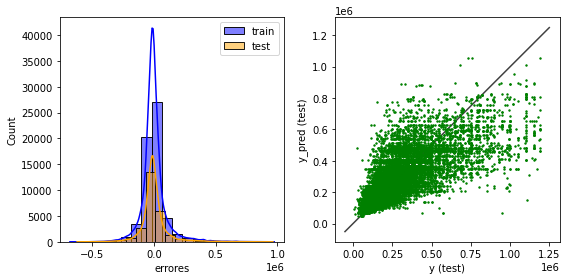

In [ ]:
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.histplot(y_train - y_train_pred, bins = 20, label = 'train', kde = True, color = 'blue')
sns.histplot(y_test - y_test_pred, bins = 20, label = 'test', kde = True, color = 'orange')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2, color = 'green')
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
   
plt.tight_layout()
plt.show()

> En el proyecto 1 se había elegido un árbol de decisión de profundidad 12 para estimar el precio de una propiedad en Capital Federal. La raíz del error cuadrático medio había sido de aproximadamente 170 000 USD.

> Para este proyecto se aplicaron métodos de pretratamiento de datos como eliminación de valores atípicos, imputación de valores faltantes, encoding y escalado de datos.

> Aplicando el mismo modelo sobre la misma selección de datos, pero con pretratamiento, el error cuadrático medio resultó ser de 100 000 USD.



---



> #### **Escalado de datos**

In [ ]:
scal = StandardScaler()
scal.fit(prope[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']])
prope[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']] = scal.transform(prope[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price_m2']])
prope.head()

,surface_covered,rooms,l3,start_date,end_date,created_on,lat,lon,l1,l2,bedrooms,bathrooms,surface_total,price,currency,title,description,property_type,operation_type,price_m2
0,0.816870,3.225944,San Cristobal,2019-10-17,2019-12-23,2019-10-17,-0.007871,0.173076,Argentina,Capital Federal,4.751484,0.580849,-0.140980,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,-0.798714
1,-0.395581,-0.799434,Boedo,2019-10-17,2019-11-21,2019-10-17,-0.046903,0.116880,Argentina,Capital Federal,-0.869534,0.580849,-0.388980,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0.165901
2,-0.587799,-0.799434,Palermo,2019-10-17,2019-11-01,2019-10-17,0.018566,0.085092,Argentina,Capital Federal,-0.869534,-0.671592,-0.477551,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta,0.580328
3,-0.513869,-0.799434,Palermo,2019-10-17,2019-12-23,2019-10-17,0.044926,0.065891,Argentina,Capital Federal,-0.869534,-0.671592,-0.335837,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,1.147367
4,-0.735659,-0.799434,La Plata,2019-10-17,2020-03-11,2019-10-17,-0.669968,1.097369,Argentina,Bs.As. G.B.A. Zona Sur,-0.869534,-0.671592,-0.459837,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta,-1.038406


> #### ***One-hot encoding* para los tipos de propiedad**

In [ ]:
# el tipo de propiedad es una variable categórica en donde no existe relacion de orden
# por este motivo se aplica one-hot encoding

prope = pd.get_dummies(prope, columns = ['property_type'])


In [ ]:
# descarto las columnas que considero que no aportan información relevante para alcanzar el objetivo del proyecto
prope = prope.drop(['created_on', 'start_date', 'end_date', 'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'], axis=1)

In [ ]:
prope.shape

(138712, 19)

In [ ]:
prope.head()

,surface_covered,rooms,lat,lon,bedrooms,bathrooms,surface_total,price,price_m2,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_PH
0,0.816870,3.225944,-0.007871,0.173076,4.751484,0.580849,-0.140980,153000.0,-0.798714,0,0,0,1,0,0,0,0,0,0
1,-0.395581,-0.799434,-0.046903,0.116880,-0.869534,0.580849,-0.388980,159000.0,0.165901,0,0,0,0,0,0,0,0,0,1
2,-0.587799,-0.799434,0.018566,0.085092,-0.869534,-0.671592,-0.477551,125000.0,0.580328,0,0,0,0,0,0,0,0,0,1
3,-0.513869,-0.799434,0.044926,0.065891,-0.869534,-0.671592,-0.335837,295000.0,1.147367,0,0,0,0,0,0,0,0,0,1
4,-0.735659,-0.799434,-0.669968,1.097369,-0.869534,-0.671592,-0.459837,40000.0,-1.038406,0,0,0,0,0,0,0,0,0,1


##PARTE B - Modelos Avanzados


1.   Elige dos de los modelos avanzados vistos. Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

2.   Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

3.    Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [ ]:
# train test split sobre los datos

X = prope.drop(['price'], axis = 1)
y = prope['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

##### · Bagging

In [ ]:
# se crea y entrena el modelo

rfr = RandomForestRegressor(
            n_estimators = 100,          #(default)
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1
            #,
            #random_state = 123
         )

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# predicciones del modelo inicial

predi = rfr.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predi,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 6025.094577145985


Valor óptimo de n_estimators: 1000


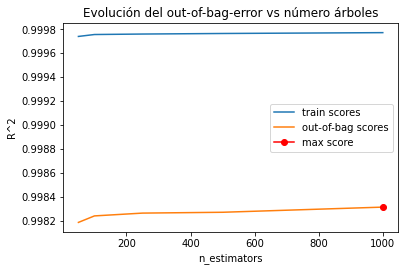

In [ ]:
# Optimización de hiperparámetros
# Validación empleando el Out-of-Bag error

train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = [50,100,250,500,1000]

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 1100


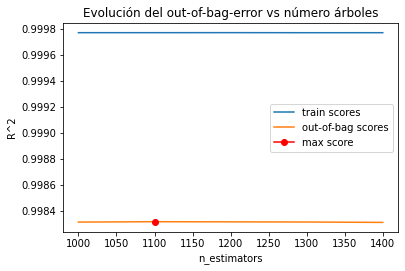

In [ ]:
# Repito Optimización de hiperparámetros

train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1000, 1500, 100)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [ ]:
# cálculo de rmse para forest de 1100

rfr1100 = RandomForestRegressor(n_estimators = 1100)
rfr1100.fit(X_train, y_train)
predi1100 = rfr1100.predict(X = X_test)

rmse1100 = mean_squared_error(
        y_true  = y_test,
        y_pred  = predi1100,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse1100}")

El error (rmse) de test es: 5887.770233719342


##### · Boosting

In [ ]:
# boosting con gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

# Grid de hiperparámetros evaluados
parameters = {'learning_rate': [0.01,0.02,0.03,0.04], # learning rate permite controlar cuan rápido aprende el modelo y con ello el riesgo de llegar al overfitting
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [10,50,100,500],
                  'max_depth'    : [1,2,3]
              }

# Búsqueda por grid search con validación cruzada
grid_GBR = GridSearchCV(estimator=GBR, #estimator: In this we have to pass the models or functions on which we want to use GridSearchCV
                        param_grid = parameters, 
                        cv = 2, #cv : In this we have to pass a interger value, as it signifies the number of splits that is needed for cross validation. By default is set as five.
                        n_jobs=-1)

grid_GBR.fit(X_train, y_train)

# Resultados
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.04, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.9918709925533584

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


In [ ]:
# Error de test del modelo final

modelo_final = grid_GBR.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 13506.15692810339


El error cuadrático medio que se estimó con la metodología bagging fue de alrededor de 5800 USD. Esto representa un valor mucho menor al obtenido en la parte A.

Los hiperparámetros fueron optimizados mediante el empleo de GridSearch en el caso de boosting, mientras que para el bagging la optimización fue manual.

Si bien el requerimiento computacional es mayor que en el proyecto 1, la diferencia en los valores de RMSE hace que valga la pena.

##PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

*   ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
*   ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

---

DESAFÍO OPCIONAL

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


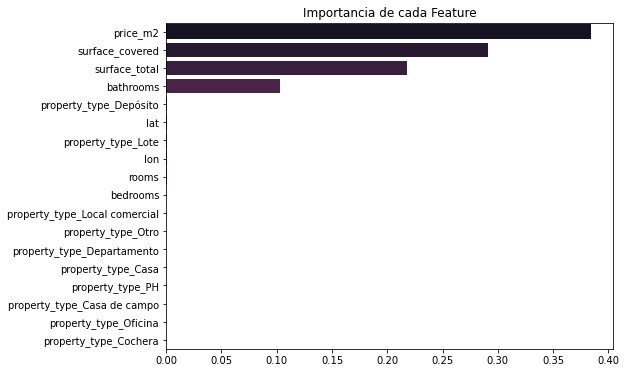

In [ ]:
# Análisis visual de la importancia de cada atributo en la predicción

importances = rfr1100.feature_importances_
columns = X.columns

# Diccionario con las columnas
lista_importances = list(importances)
lista_columnas = list(columns)
dicc = dict(zip(lista_columnas,lista_importances))

# Orden
import operator
dicc = sorted(dicc.items(), key=operator.itemgetter(1), reverse = True)

# Lista con el orden de importancia
orden = []
for columna, valor in dicc:
    orden.append(columna)

plt.figure(figsize=(8,6))
sns.barplot(importances, columns, order = orden, palette='rocket')
plt.xticks(rotation=0)
plt.title('Importancia de cada Feature')
plt.show()

Se puede observar que el precio del inmueble por m$^2$ es el atributo que más influye al momento de estimar el precio de una propiedad, algo que de hecho era esperado. Le siguen las superficies cubierta y total.

En un principio hubiera creído que el tipo de propiedad influiría en su precio con más peso que la cantidad de baños. Por ejemplo, se esperaría que un departamento y una casa con la misma superficie cubierta no valieran lo mismo debido a que poseen diferencias en cuanto a la independencia en su acceso. Sin embargo, esto no se evidencia en la visualización de importancia de cada feature.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


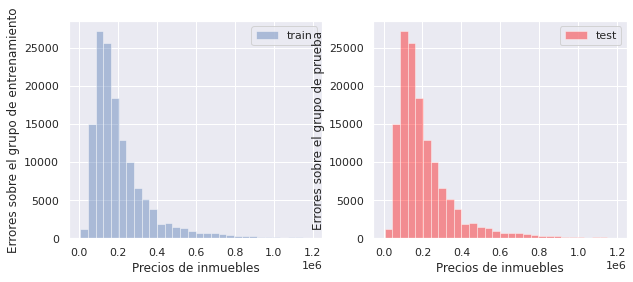

In [ ]:
# Errores

rfr1100.fit(X_train, y_train)

y_train_pred = rfr1100.predict(X_train)
y_test_pred = rfr1100.predict(X_test)

errores_train = y_train_pred - y_train
errores_test = y_test_pred - y_test

# Visualización de errores en la predicción del precio de los inmuebles
sns.set()
plt.figure(figsize = (10,4))

# Errores train
plt.subplot(1,2,1)
sns.distplot(errores_train, bins = 30, label = 'train', x = prope['price'], kde = False)
plt.xlabel('Precios de inmuebles')
plt.ylabel('Errores sobre el grupo de entrenamiento')
plt.legend();

# Errores test
plt.subplot(1,2,2)
sns.distplot(errores_test, bins = 30, label = 'test', x = prope['price'], kde = False, color = 'red')
plt.xlabel('Precios de inmuebles')
plt.ylabel('Errores sobre el grupo de prueba')
plt.legend();


Se observan distribuciones similares en los errores tanto para los conjuntos de test como de train. En ambos casos el pico de errores ocurre en los inmuebles que poseen un precio de alrededor de 100.000 USD.

**Discusión y conclusiones**

En este proyecto 2 fue posible realizar un preprocesamiento adecuado de los datos que permitiera desarrollar un modelo que prediga el precio de una propiedad. En la sección A fueron detallados cada uno de ellos. Esta serie de mejoras se reflejaron en una disminución del error cuadrático medio en comparación con los resultados obtenidos en el proyecto 1.

Luego se procedió a aplicar modelos avanzados de machine learning que mejoraran aun más las estimaciones de los precios. Se llevaron a cabo tareas de bagging y boosting con sus respectivas optimizaciones de hiperparámetros. Estas metodologías arrojaron valores que resultan más que satisfactorios en el marco del objetivo de este trabajo.


---



##Checklist de evaluación
Sugerencias para desarrollar el proyecto:

* Este proyecto no cuenta con mínimos entregables indicados en la consigna, pero ten en cuenta lo siguiente:
 * en la Parte A debes implementar al menos tres de las transformaciones de datos propuestas.
 * en la Parte B, al menos un modelo debe ser optimizado por Grid Search o Random Search; el otro puede ser optimizado por búsqueda manual (es decir, puedes dejar los mejores parámetros que encontraste probando).
 * en la Parte C, debes responder al menos una pregunta. Obviamente, ¡cuanto más hagas, más aprenderás y mejor será tu proyecto!

* La resolución del proyecto te puede enfrentar a pequeños desafíos que no trabajamos durante los encuentros. Es importante que desarrolles la capacidad de resolverlos. Para ello, consulta las bitácoras, las referencias, los notebooks vistos en clase, la documentación de la librería y, sobre todo, googlea.

Antes de subir tu proyecto a la plataforma Acámica para que sea evaluado, verifica que el Notebook se ejecute sin errores. Además, asegúrate de cumplir con las siguientes condiciones (son las que los/as evaluadores/as tendrán en consideración al momento de corregir tu trabajo):

###PARTE A - Transformación de Datos

1.    Debes justificar por qué creés que las transformaciones elegidas aplican en este dataset. Ten en cuenta que, en el manejo de valores atípicos o en la imputación de valores faltantes, los valores obtenidos deben tener sentido. Por ejemplo, valores mayores que cero para superficies, número de baños, etc.
2.    Debes re entrenar un modelo del Proyecto 01 y comparar su desempeño con el modelo obtenido en el Proyecto 01. Una aclaración: con reentrenar nos referimos a usar el mismo proceso de entrenamiento junto con sus hiperparámetros. Pero puede ocurrir - y, de hecho, se espera - que el dataset contenga más atributos que los utilizados en el Proyecto 01.

###PARTE B - Modelos Avanzados

En la optimización de hiperparámetros, debes justificar los parámetros que elegiste para optimizar y el rango de cada uno.

###PARTE C - Interpretación de modelos

1. Debes estudiar qué variables utiliza el modelo para predecir y responder la pregunta: ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
2. Es muy importante que analices los errores del modelo. ¿Dónde es mayor el error? ¿dónde acierta?
3. Debes ser crítico/a con la metodología utilizada. ¿Qué mejorarías? Ten en cuenta siempre terminar con una discusión sobre lo realizado y conclusiones obtenidas.